## Постановка задачи

### Description

Вам предоставлен набор данных — некоторых вещественно значных признаков. Вам нужно проставить метки классов, другими словами кластеризовать данные.

### Evaluation

Метрика оценки качества — Adjusted Rand Score.

Ваш файл решения должен иметь следующий вид:

'''csv
ID,TARGET
0,0
1,1
2,2
3,3
4,4
...
'''

Данные — sparse матрица размера (14590, 77888).

### Files

train.npz - набор данных, по которым необходимо предсказать метки.

sample_submission.csv - пример файла решения

### Загрузка данных

from scipy import sparse

train = sparse.load_npz("train.npz")

### Подключение окружения

#### pip

In [1]:
!pip install scipy numpy pandas emot nltk wordsegment optuna pymorphy3 umap-learn pymorphy3-dicts-ru tqdm xgboost catboost scikit-learn matplotlib seaborn progressbar2

#### import

In [1]:
import numpy as np
import pandas as pd
import re
import warnings
import time
import matplotlib.pyplot as plt
from matplotlib import animation
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from progressbar import progressbar
from nltk.tokenize import RegexpTokenizer
from nltk.stem import SnowballStemmer
from tqdm import notebook
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.multioutput import MultiOutputClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import *
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, adjusted_rand_score, jaccard_score
from scipy import sparse
from sklearn.pipeline import make_pipeline
import umap.umap_ as umap
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import LogNorm
from scipy.stats import kde

%matplotlib inline 

#### Полезные функции

In [2]:
def saveLabels(labels, filename='hw4_result.csv'):
    test_df = pd.read_csv("sample_submission.csv")
    test_df["TARGET"] = labels
    test_df[["ID", "TARGET"]].to_csv(filename, index=False)

In [3]:
def plotVision(metric, df, lbls=None):
    plt.figure(figsize=[16, 8])
    plt.subplot(1, 2, 1)
    plt.scatter(df[:, 0], df[:, 1], alpha=0.27, c=lbls )
    plt.title(metric)
    plt.grid()
    plt.subplot(1, 2, 2)
    sns.kdeplot(x=df[:, 0], y=df[:, 1], fill=True, thresh=0, levels=100, cmap="mako", cbar=False)
    plt.title('Карта плотностей')
    plt.show()

In [76]:
def plotMetricsResult(lbls_best, lbls, _pca_df=svd_df, _tsne_df=tsne_df, _umap_df=umap_df):
    plt.figure(figsize=[16, 8])

    plt.subplot(2, 3, 1)
    plt.scatter(_pca_df[:, 0], _pca_df[:, 1], alpha=0.27, c=lbls )
    plt.title('PCA')
    plt.grid()

    plt.subplot(2, 3, 2)
    plt.scatter(_tsne_df[:, 0], _tsne_df[:, 1], alpha=0.27, c=lbls )
    plt.title('t-SNE')
    plt.grid()

    plt.subplot(2, 3, 3)
    plt.scatter(_umap_df[:, 0], _umap_df[:, 1], alpha=0.27, c=lbls )
    plt.title('UMAP')
    plt.grid()

    plt.subplot(2, 3, 4)
    plt.scatter(_pca_df[:, 0], _pca_df[:, 1], alpha=0.27, c=lbls_best )
    plt.title('PCA best')
    plt.grid()

    plt.subplot(2, 3, 5)
    plt.scatter(_tsne_df[:, 0], _tsne_df[:, 1], alpha=0.27, c=lbls_best )
    plt.title('t-SNE best')
    plt.grid()

    plt.subplot(2, 3, 6)
    plt.scatter(_umap_df[:, 0], _umap_df[:, 1], alpha=0.27, c=lbls_best )
    plt.title('UMAP best')
    plt.grid()

    plt.show()

In [191]:
def plotKMeans(df, labels, model):
    plt.figure(figsize=[12, 6])
    plt.subplot(1, 2, 1)
    centroids = model.cluster_centers_
    plt.scatter(df[:, 0], df[:, 1], alpha=0.27, c=labels )
    plt.scatter(centroids[:, 0], centroids[:, 1], linewidths=10, marker ="x", color='black')
    plt.subplot(1, 2, 2)
    sns.kdeplot(x=df[:, 0], y=df[:, 1], fill=True, thresh=0, levels=100, cmap="mako", cbar=False)
    plt.show()

In [192]:
def plotGMM(df, labels):
    plt.figure(figsize=[6, 6])
    plt.scatter(df[:, 0], df[:, 1], alpha=0.27, c=labels )
    plt.show()

In [193]:
def plotSCM(df, labels):
    plt.figure(figsize=[6, 6])
    plt.scatter(df[:, 0], df[:, 1], alpha=0.27, c=labels )
    plt.show()

## Подготовка данных

In [6]:
train = sparse.load_npz("train.npz")
X = train

In [7]:
X

<14590x77888 sparse matrix of type '<class 'numpy.float64'>'
	with 2026769 stored elements in Compressed Sparse Row format>

In [8]:
X.shape

(14590, 77888)

## Modeling

### Визуализация

#### PCA (SVD)

In [117]:
%%time
svd = TruncatedSVD(n_components=2)
svd_df = svd.fit_transform(X)

CPU times: user 2.54 s, sys: 1.38 s, total: 3.92 s
Wall time: 549 ms


In [118]:
svd_df

array([[ 0.09119625,  0.00150029],
       [ 0.09078267,  0.00861411],
       [ 0.08260834,  0.00302633],
       ...,
       [ 0.10094115, -0.00022347],
       [ 0.11317277,  0.02483555],
       [ 0.19189452,  0.02678824]])

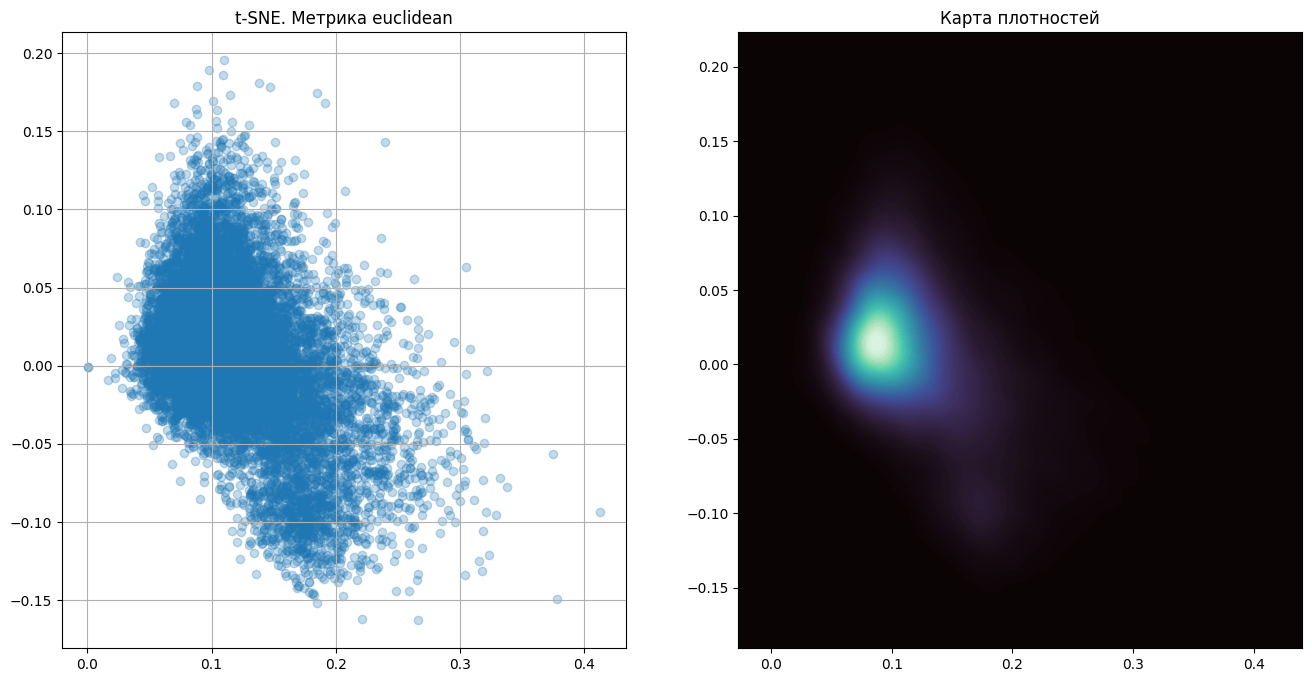

In [11]:
plotVision("t-SNE. Метрика euclidean", svd_df)

PCA(SVG) в данной задаче использовать будет не эффективно, так как колличество компонентов будет очень большим.

#### t-SNE

In [164]:
%%time
tsne = TSNE(n_components=2, perplexity=50, metric='euclidean', init='random', verbose=1)
tsne_df = tsne.fit_transform(X)

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 14590 samples in 0.008s...
[t-SNE] Computed neighbors for 14590 samples in 10.571s...
[t-SNE] Computed conditional probabilities for sample 1000 / 14590
[t-SNE] Computed conditional probabilities for sample 2000 / 14590
[t-SNE] Computed conditional probabilities for sample 3000 / 14590
[t-SNE] Computed conditional probabilities for sample 4000 / 14590
[t-SNE] Computed conditional probabilities for sample 5000 / 14590
[t-SNE] Computed conditional probabilities for sample 6000 / 14590
[t-SNE] Computed conditional probabilities for sample 7000 / 14590
[t-SNE] Computed conditional probabilities for sample 8000 / 14590
[t-SNE] Computed conditional probabilities for sample 9000 / 14590
[t-SNE] Computed conditional probabilities for sample 10000 / 14590
[t-SNE] Computed conditional probabilities for sample 11000 / 14590
[t-SNE] Computed conditional probabilities for sample 12000 / 14590
[t-SNE] Computed conditional probabilities for s

In [165]:
tsne_df

array([[ 23.011238 ,  31.476866 ],
       [-23.453352 ,  45.297268 ],
       [ 38.833096 ,  42.07342  ],
       ...,
       [-51.508026 , -10.1895485],
       [ -1.7120026,  -4.3047066],
       [ 15.609254 ,  13.299866 ]], dtype=float32)

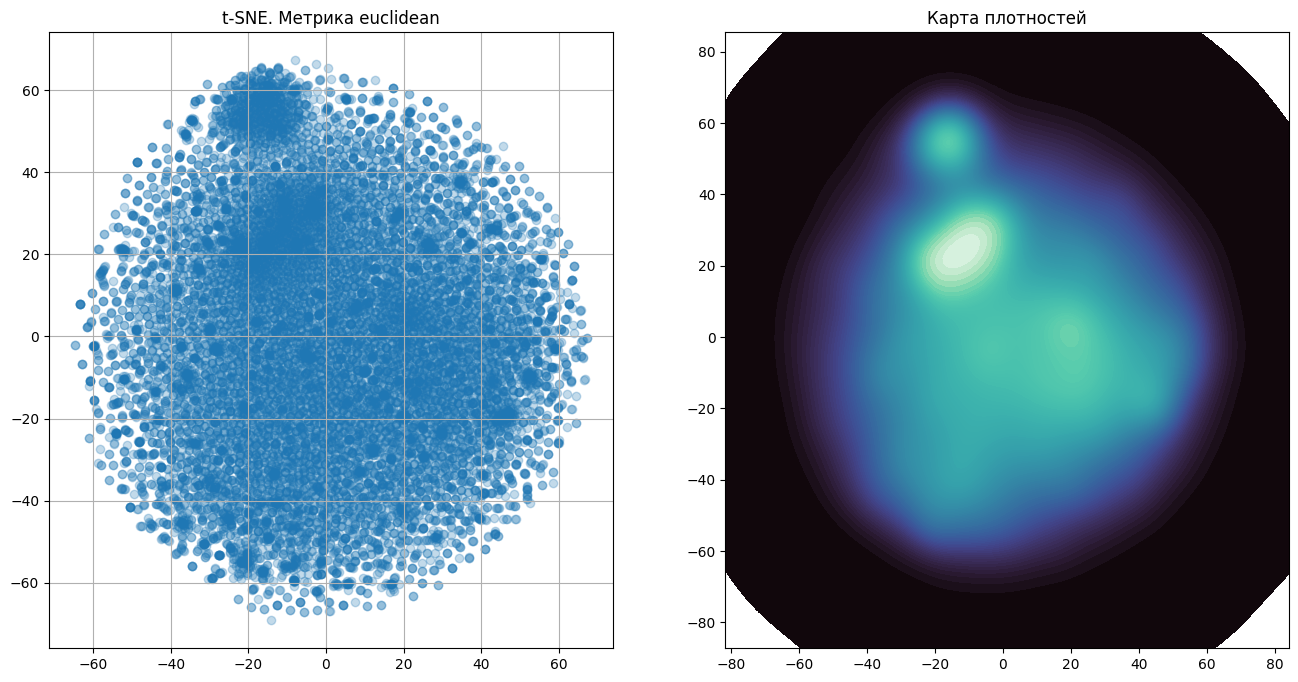

In [166]:
plotVision("t-SNE. Метрика euclidean", tsne_df)

#### UMAP

In [145]:
%%time
umapm = umap.UMAP(n_components=3)
umap_df = umapm.fit_transform(X)

CPU times: user 1min 4s, sys: 1.23 s, total: 1min 5s
Wall time: 13.1 s


In [146]:
umap_df

array([[10.22316  ,  8.065365 ,  1.2629296],
       [ 5.251229 ,  8.088641 ,  4.0561395],
       [ 9.645475 ,  6.7681394,  2.622672 ],
       ...,
       [ 7.692359 ,  7.2386556,  1.9275327],
       [10.399254 ,  8.293858 ,  2.7367082],
       [ 9.2602215,  6.103056 ,  3.2234085]], dtype=float32)

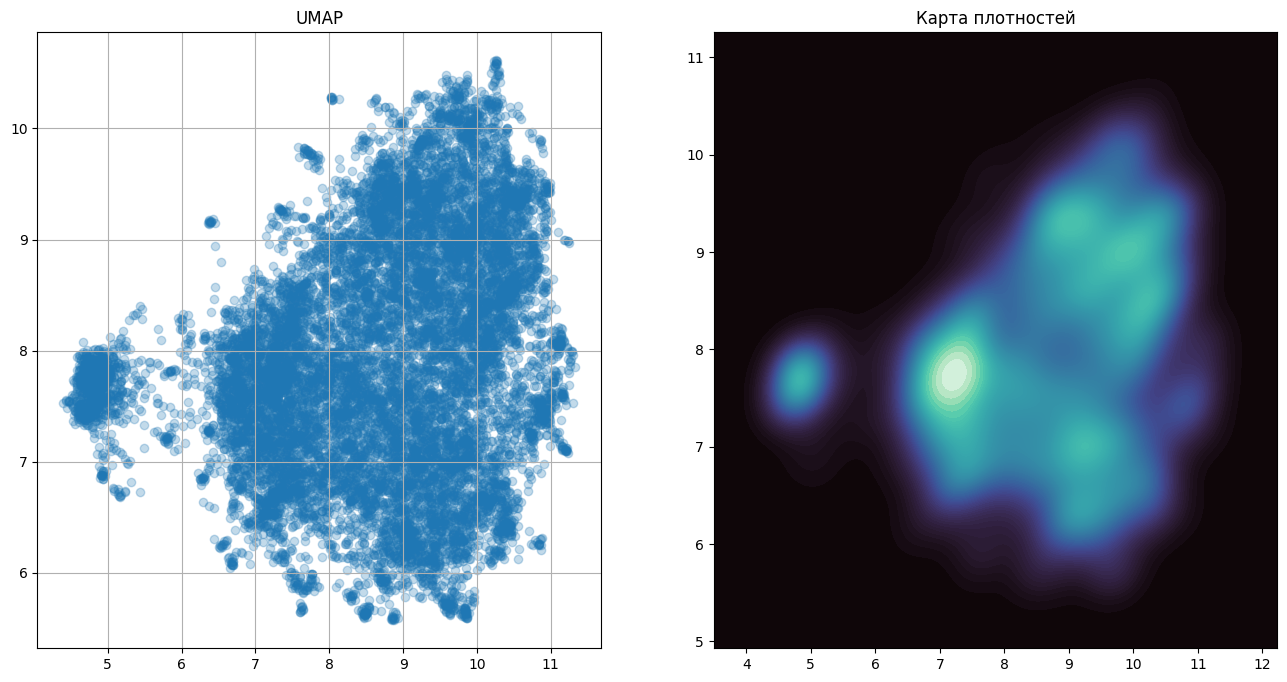

In [147]:
plotVision("UMAP", umap_df)

Видно, что формируется 2 скомпления точек, одно из которых больше другого. Есть отдельные скопления, но между ними есть заполненное пространство. При таком подходе алгоритмы кластеризации, использующие расстояния между точками, ничего хорошего выдавать не будут.

#### Метод локтя

Для трех наборов данных сделаем замеры метода локтя. Помимо колличества кластеров, мы так же сможет увидеть взаимосвязь между наборами данных

In [18]:
N = 20

In [19]:
crit_x = []
for k in progressbar(range(2, N)):
    kmeans = KMeans(n_clusters=k).fit(X)
    crit_x.append(np.sqrt(kmeans.inertia_))

100% (18 of 18) |########################| Elapsed Time: 0:00:19 Time:  0:00:190102


In [26]:
crit_tsne = []
for k in progressbar(range(2, 50)):
    kmeans = KMeans(n_clusters=k).fit(tsne_df)
    crit_tsne.append(np.sqrt(kmeans.inertia_))

100% (48 of 48) |########################| Elapsed Time: 0:00:02 Time:  0:00:020000


In [21]:
crit_umpa = []
for k in progressbar(range(2, N)):
    kmeans = KMeans(n_clusters=k).fit(umap_df)
    crit_umpa.append(np.sqrt(kmeans.inertia_))

100% (18 of 18) |########################| Elapsed Time: 0:00:00 Time:  0:00:000000


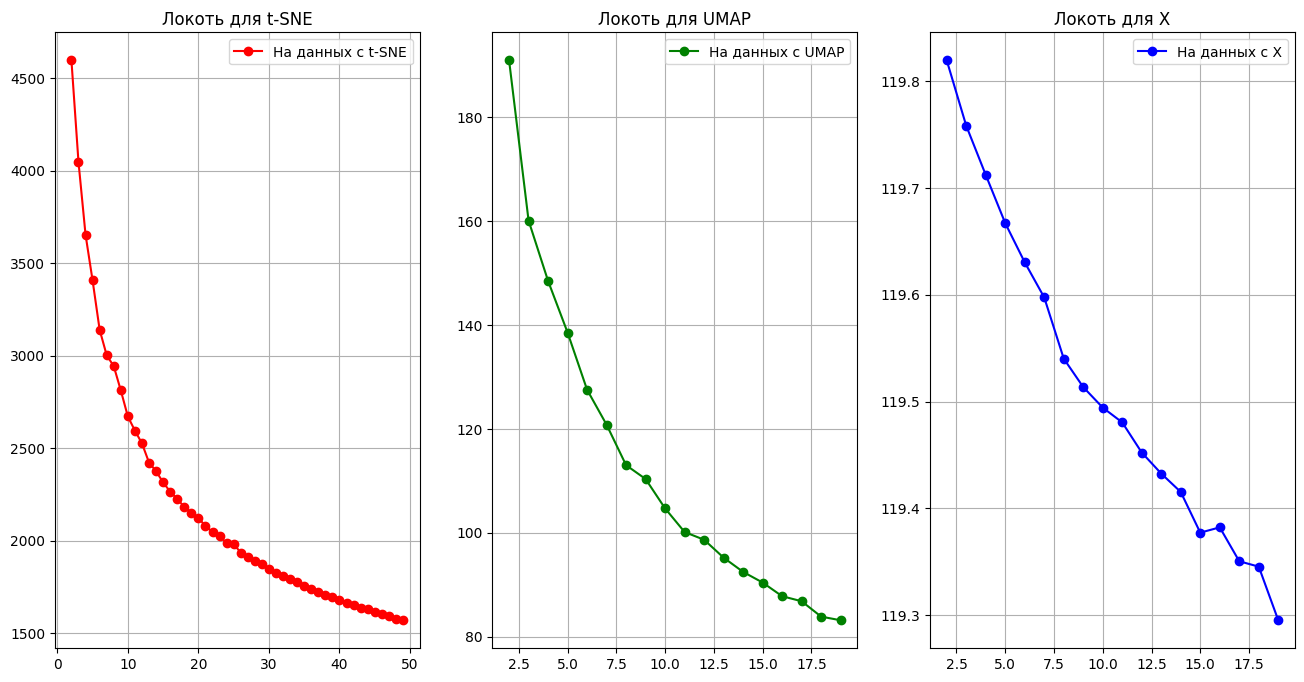

In [28]:
plt.figure(figsize=[16, 8])

plt.subplot(1, 3, 1)
plt.plot(range(2, 50), crit_tsne, 'o-r', label='На данных c t-SNE')
plt.title('Локоть для t-SNE')
plt.legend()
plt.grid()

plt.subplot(1, 3, 2)
plt.title('Локоть для UMAP')
plt.plot(range(2, N), crit_umpa, 'o-g', label='На данных с UMAP')
plt.grid()
plt.legend()

plt.subplot(1, 3, 3)
plt.title('Локоть для X')
plt.plot(range(2, N), crit_x, 'o-b', label='На данных с X')
plt.grid()
plt.legend()

plt.show()

По графикам можно сказать, что UMAP можно наложить на изначальный данные. В то время как у t-SNE Слишком искажены. Колличество кластеров 7. В дальнейшем, для обчучения будем использовать **umap_df**

### Кластеризируем

#### Выбор моделей для анализа

Посмотрим еще раз на данные

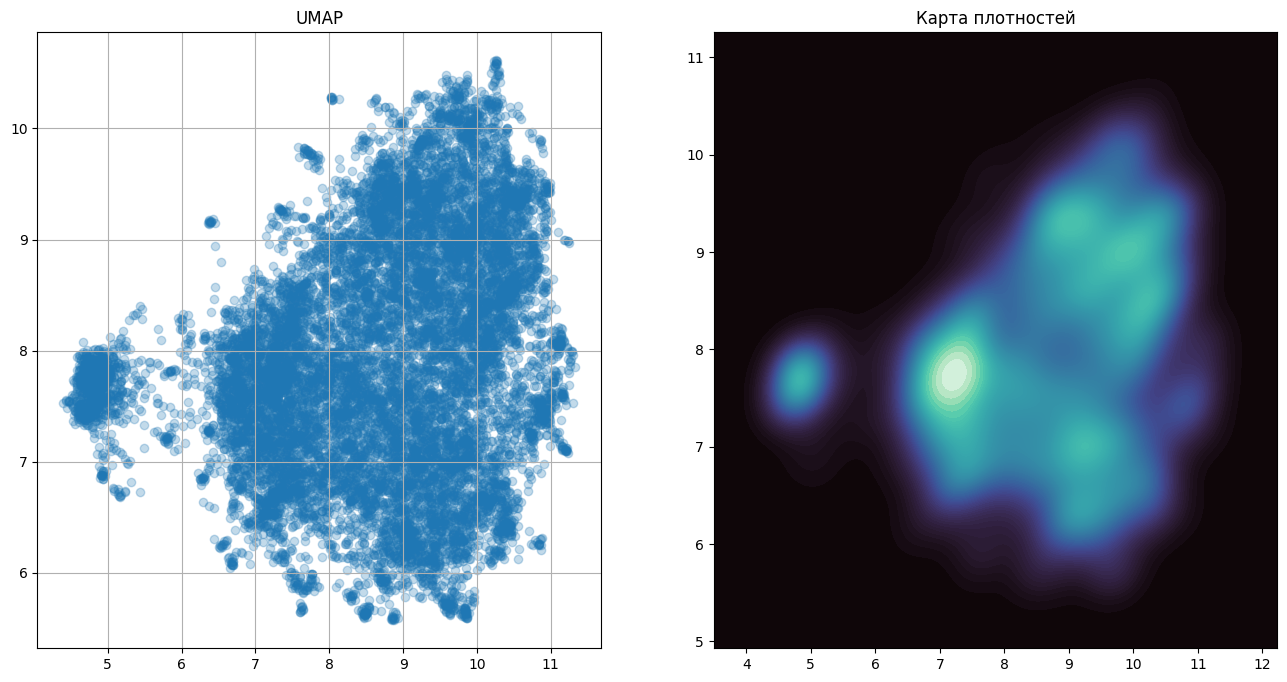

In [167]:
plotVision("UMAP", umap_df)

Используем для оценки KMeans, GaussianMixture и SpectralClustering

![](https://scikit-learn.ru/wp-content/uploads/2021/01/sphx_glr_plot_cluster_comparison_0011-2048x1219.png)

#### KMeans

##### firstlaunch

In [168]:
km = KMeans(n_clusters=7, algorithm='lloyd', init='random', max_iter=500, tol=1e-05)

In [169]:
%%time
km_labels = km.fit_predict(umap_df)
km_labels

CPU times: user 409 ms, sys: 428 ms, total: 836 ms
Wall time: 154 ms


array([5, 0, 6, ..., 2, 6, 6], dtype=int32)

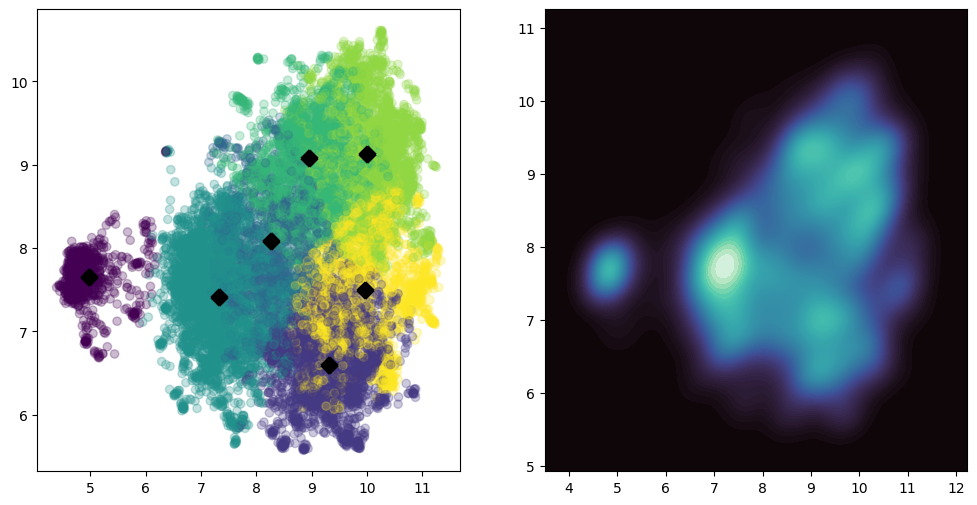

In [170]:
plotKMeans(umap_df, km_labels, km)

In [171]:
saveLabels(km_labels)

Результат получается: 0.05479182076353936

##### Попробуем поиграть с параметрами

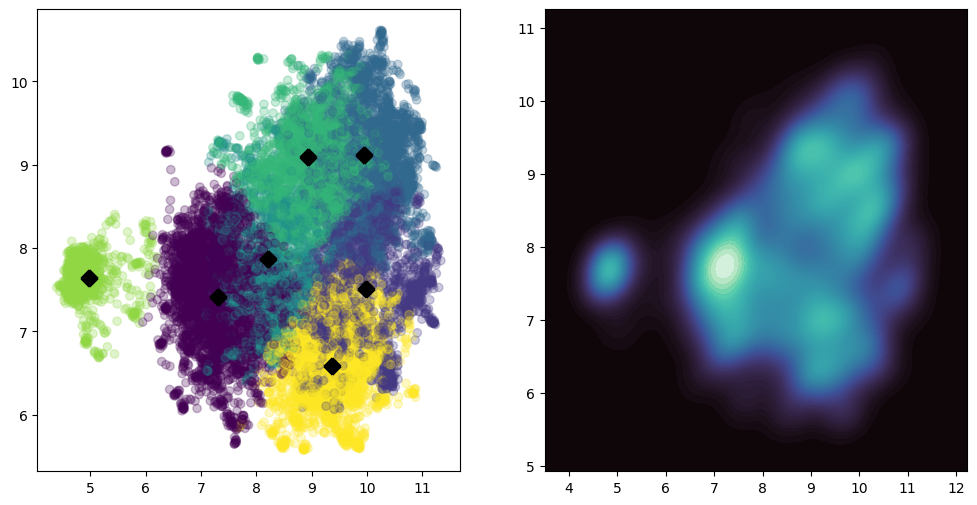

In [172]:
km_param = KMeans(n_clusters=7, algorithm='lloyd', init='k-means++', max_iter=1000).fit(umap_df)
km_param_labels = km_param.predict(umap_df)
plotKMeans(umap_df, km_param_labels, km_param)

In [173]:
saveLabels(km_param_labels)

Результат: 0.062187433135184475

Эффекта особого нету...

##### Попробуем взять по чистым данным

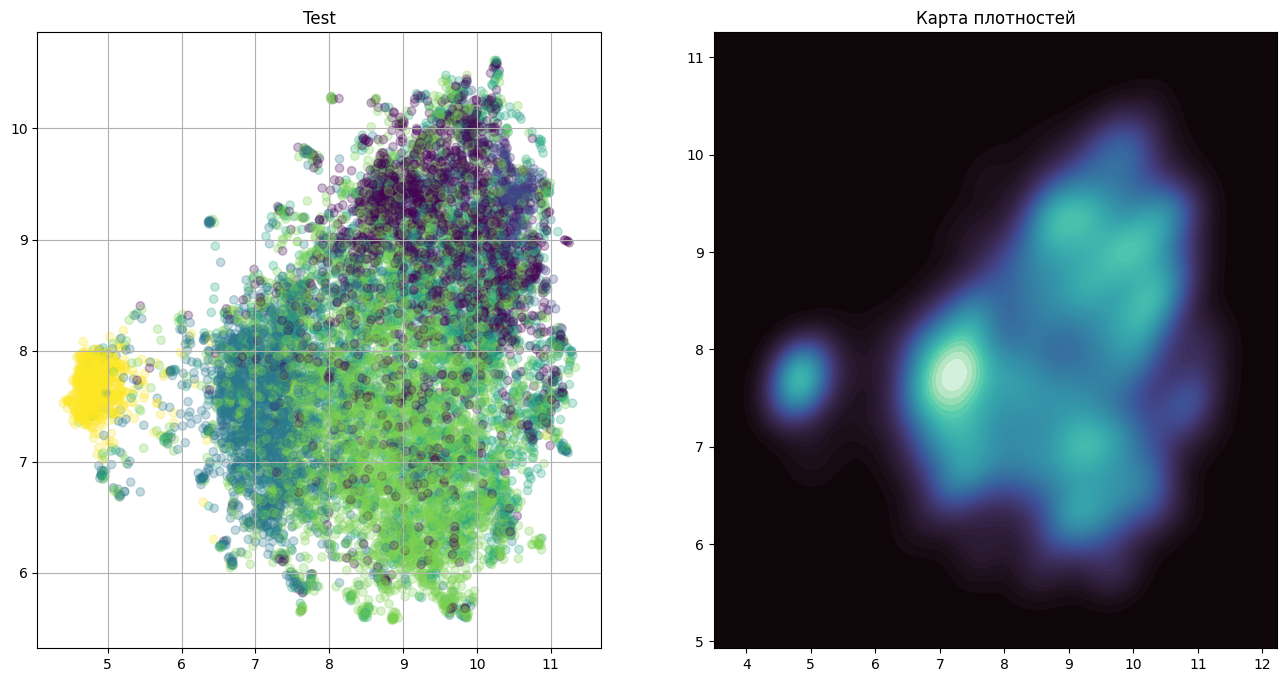

In [174]:
km_param_X = KMeans(n_clusters=6, algorithm='lloyd', init='random', max_iter=1000)
km_param_X.fit(X)
km_param_X_labels = km_param_X.predict(X)
plotVision( "Test", umap_df, km_param_X_labels)

KMeans - это метод кластеризации, который часто используется для разделения данных на группы на основе их сходства. Результаты кластеризации могут отличаться в зависимости от входных данных.

UMAP (Uniform Manifold Approximation and Projection) - это метод снижения размерности и визуализации данных, который помогает сохранить глобальную структуру данных. Он может изменить распределение точек в пространстве, что влияет на результаты работы KMeans.

Из-за этого разница в результатах кластеризации между оригинальными данными и данными после обработки UMAP вполне естественна.

In [175]:
saveLabels(km_param_X_labels, "hw4_result_km_param_X_labels.csv")

Лучший результат был: 0.12049660758684722

#### GaussianMixture

##### firstlaunch

In [176]:
gmm = GaussianMixture(n_components=7)

In [177]:
gmm_labels = gmm.fit_predict(umap_df)

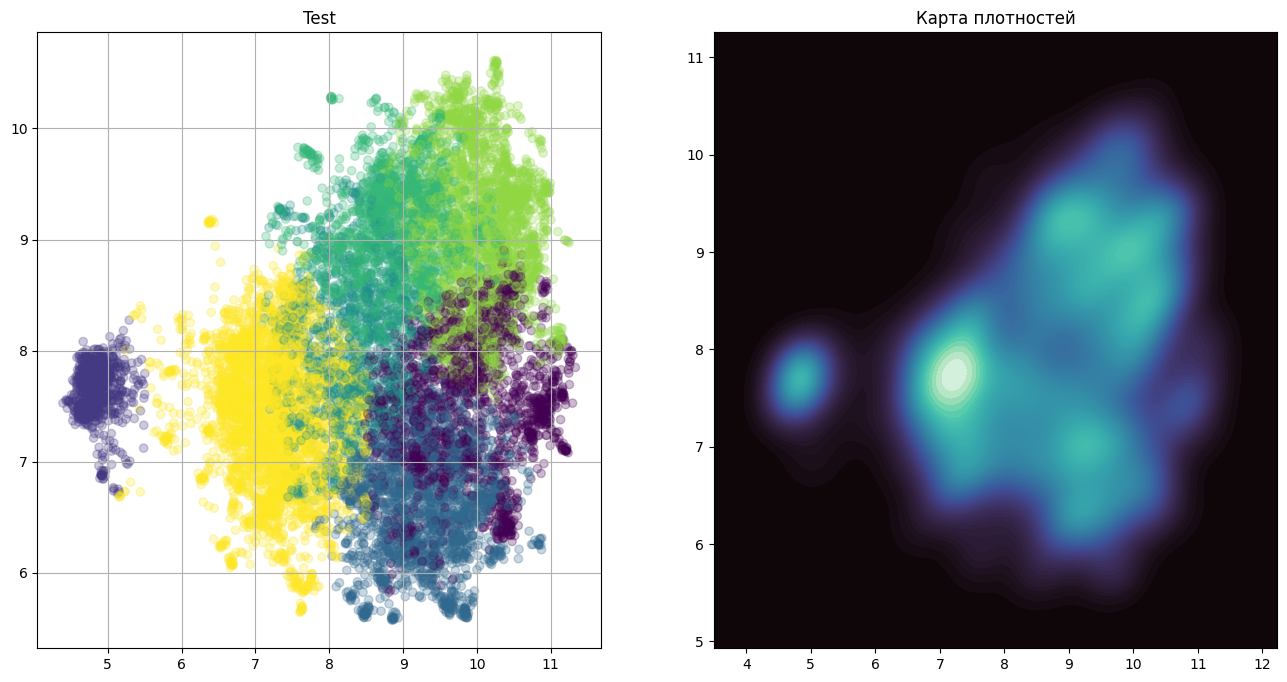

In [178]:
plotVision("Test", umap_df, gmm_labels)

##### Подберем параметры

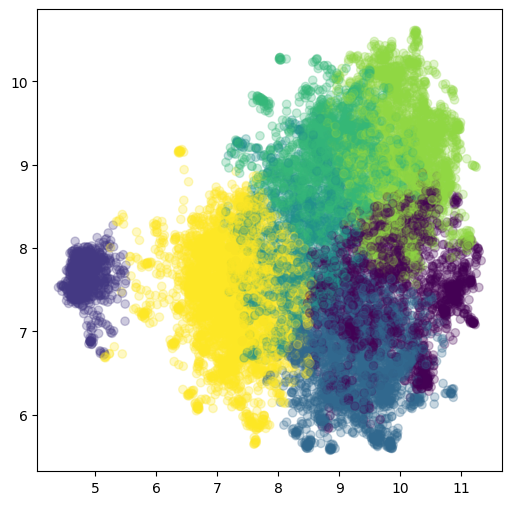

In [179]:
gmm_param_labels = GaussianMixture(n_components=7, covariance_type='spherical', tol=1e-6,
                                   init_params='kmeans', max_iter=1000, 
                                   random_state=42).fit_predict(umap_df)
plotGMM(umap_df, gmm_labels)

В целом подбор параметров вообще ничего не поменял. Более того результат похож на KMeans +-

In [180]:
saveLabels(gmm_labels)

##### Попробуем по чистым параметрам

In [209]:
# gmm_X_labels = GaussianMixture(n_components=7, verbose=1).fit_predict(X_array)

Плохая идея передавать массив целиком, моя система упала...

##### BayesianGaussianMixture

/opt/homebrew/lib/python3.11/site-packages/sklearn/mixture/_base.py:268: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


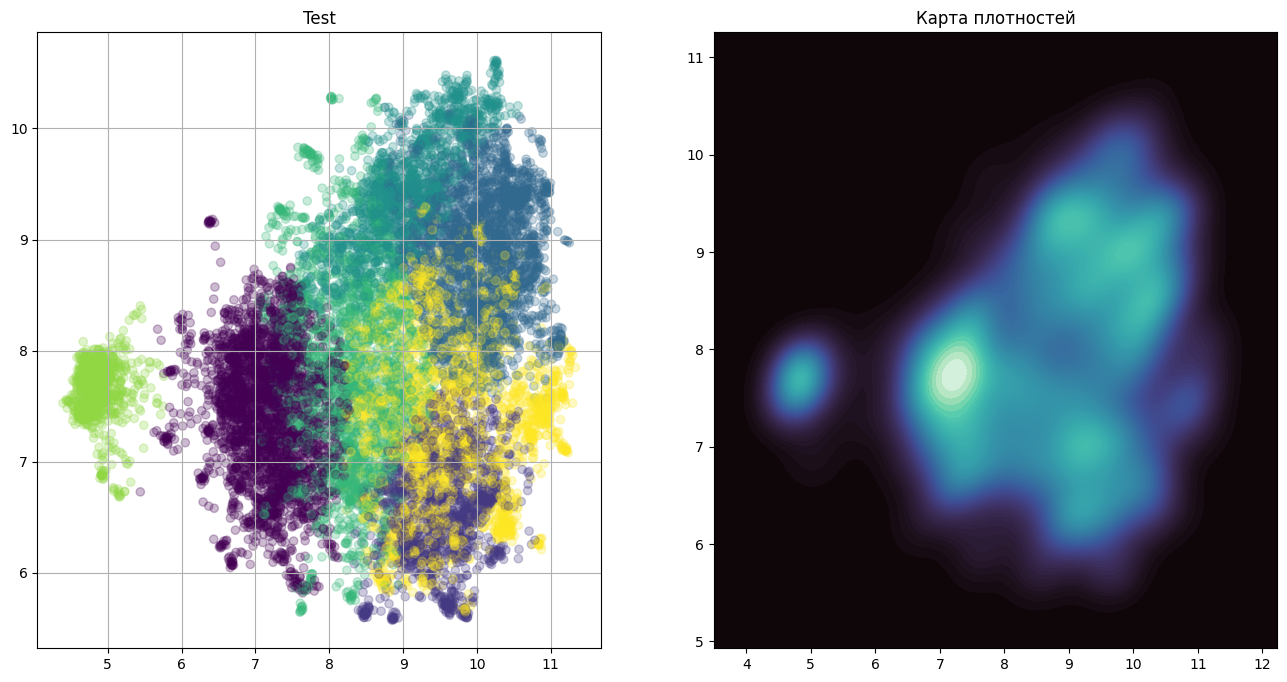

In [181]:
bgmm_labels = BayesianGaussianMixture(n_components=7).fit_predict(umap_df)
plotVision("Test", umap_df, bgmm_labels)

In [182]:
saveLabels(bgmm_labels, 'hw4_bgmm_labels.csv')

Результат: 0.06299464752618693

Интересный результат, в целом он схож с плотностью +-

/opt/homebrew/lib/python3.11/site-packages/sklearn/mixture/_base.py:268: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


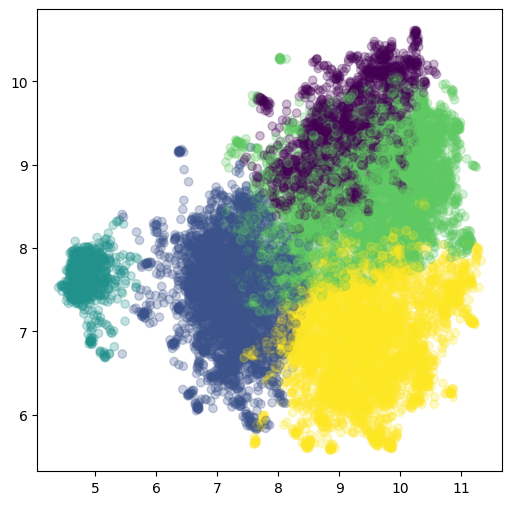

In [183]:
bgmm_param_labels = BayesianGaussianMixture(n_components=5, tol=1e-6, init_params='random',
                                            max_iter=500).fit_predict(umap_df)
plotGMM(umap_df, bgmm_param_labels)

In [184]:
saveLabels(bgmm_param_labels)

Результат: 0.09066487216027241

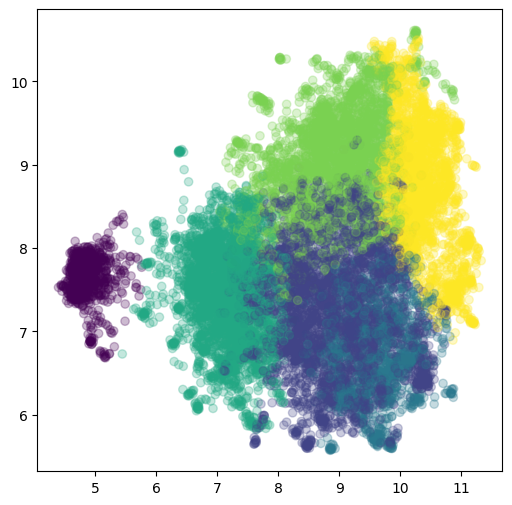

In [185]:
bgmm_param_labels_1 = BayesianGaussianMixture(n_components=6, tol=1e-1, init_params='random',
                                              max_iter=1000).fit_predict(umap_df)
plotGMM(umap_df, bgmm_param_labels_1)

In [236]:
saveLabels(bgmm_param_labels_1)

Результат: 0.0515428929266775

В целом модель дает интересные результаты, надо будет их проверить.

GMM не оправдала ожиданий

#### SpectralClustering

##### firstlaunch

In [186]:
scm = SpectralClustering(n_components=6)

In [187]:
%%time
scm_labels = scm.fit_predict(umap_df)

CPU times: user 1min 46s, sys: 32.5 s, total: 2min 18s
Wall time: 25.1 s


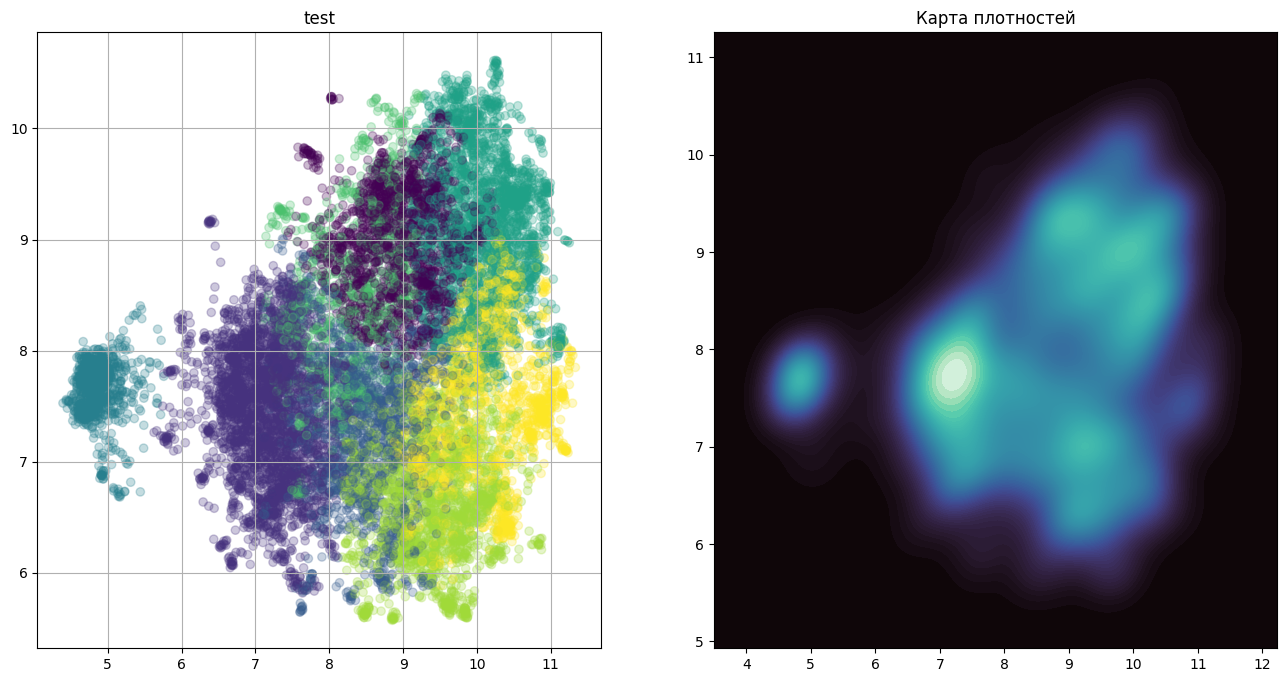

In [188]:
plotVision("test", umap_df, scm_labels)

In [251]:
saveLabels(scm_labels)

Результат: 0.04811854653338116

Результат похож на BayesianGaussianMixture(). Надо играть с параметрами

##### SpectralClustering с параметрами

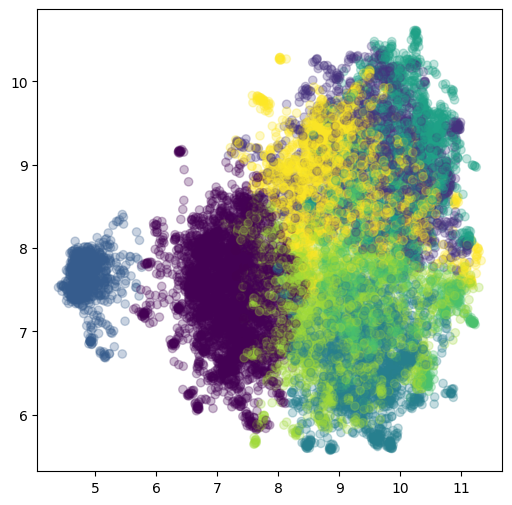

In [194]:
scm_param_labels_0 = SpectralClustering(n_components=5, eigen_solver=None, 
                                        gamma=1.0, n_neighbors=8, assign_labels='kmeans', 
                                        random_state=42).fit_predict(umap_df)
plotSCM(umap_df, scm_param_labels_0)

In [238]:
saveLabels(scm_param_labels_0)

/opt/homebrew/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:301: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


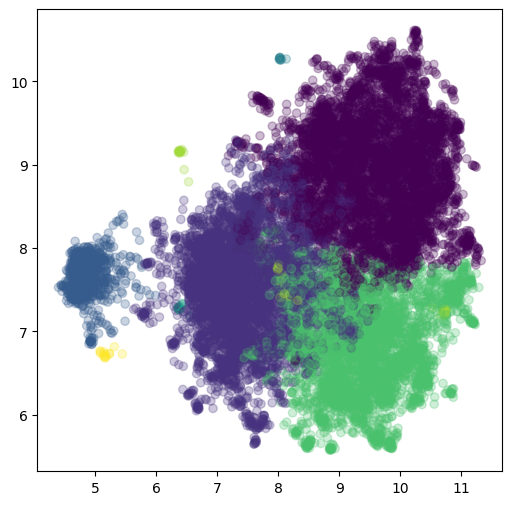

In [195]:
scm_param_labels_1 = SpectralClustering(n_components=6, eigen_solver=None, affinity='nearest_neighbors', 
                                        gamma=1.0, n_neighbors=8, assign_labels='kmeans', 
                                        random_state=42).fit_predict(umap_df)
plotSCM(umap_df, scm_param_labels_1)

In [222]:
saveLabels(scm_param_labels_1)

Результат: 0.06228887150891589

/opt/homebrew/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:301: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


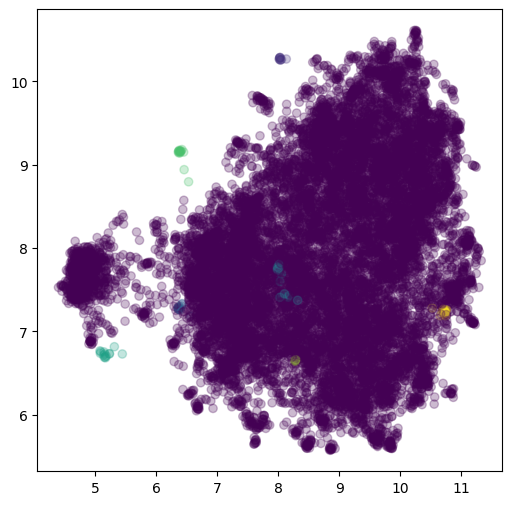

In [196]:
scm_param_labels_0 = SpectralClustering(n_components=5, eigen_solver=None, affinity='nearest_neighbors', 
                                        gamma=10.0, n_neighbors=8, assign_labels='kmeans', 
                                        random_state=42).fit_predict(umap_df)
plotSCM(umap_df, scm_param_labels_0)

Результат: **-0.03361968001421324**

### Best

In [29]:
best_score_df = pd.read_csv("score_best.csv")
best_score = np.array(best_score_df['TARGET'])
best_score

array([0, 0, 4, ..., 0, 4, 1])

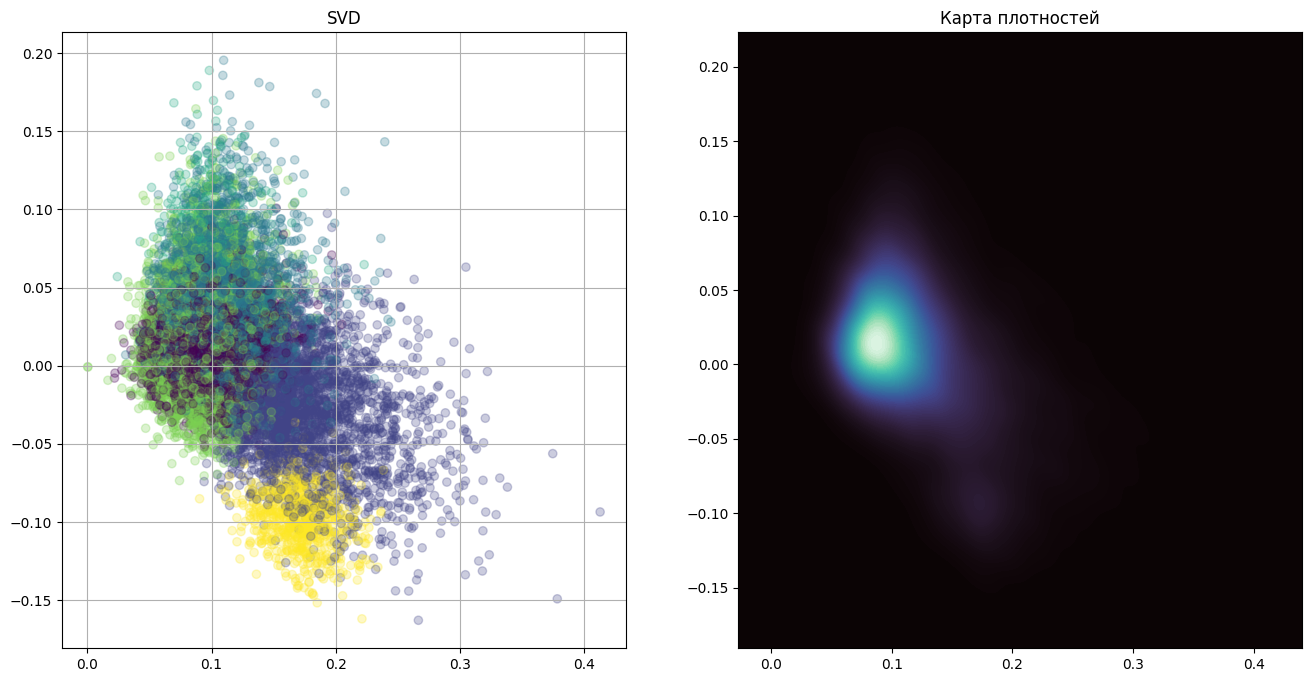

In [30]:
plotVision("SVD", svd_df, best_score)

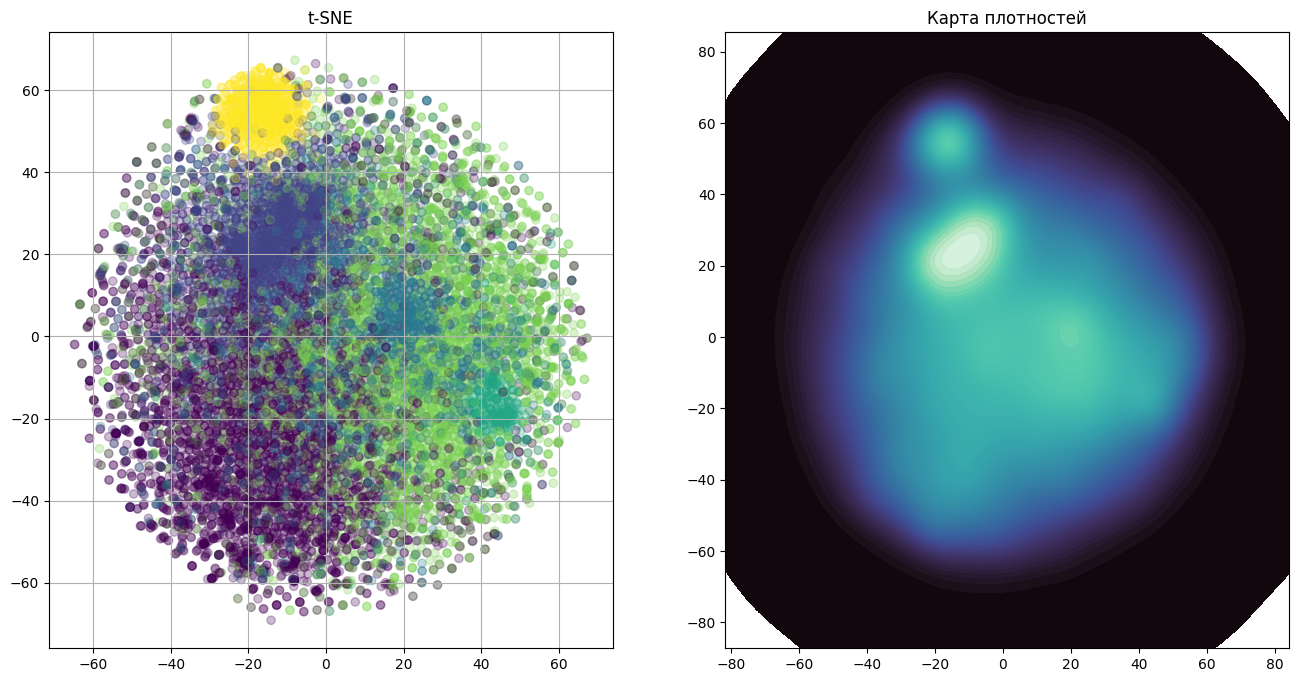

In [198]:
plotVision("t-SNE", tsne_df, best_score)

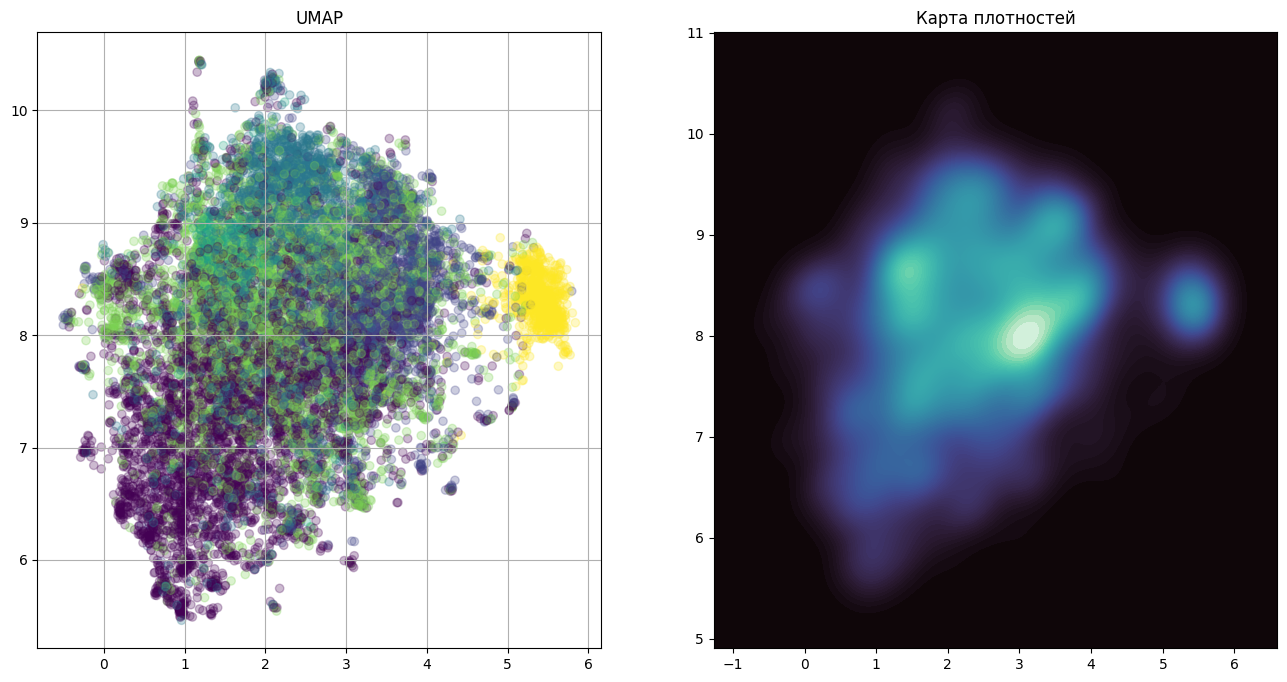

In [32]:
plotVision("UMAP", umap_df, best_score)

#### Лучшая выборка

Идея сомнительная, но в общем: с помощью *adjusted_rand_score* подобрать близкое соотношение >0.75 из *KMeans* - тем самым можно попасть в 0.127. Это будет возможно из-за того, что значения будут близки к лучшему на данный момент score, но немного отличатся и этот отличие может сыграть на совпадение

In [73]:
cutoff = 0.85

In [154]:
def makeCheckGroup(sroce_best, train_df, n_attempt, co=cutoff):
    result = []
    for i in progressbar(range(0, n_attempt)):
        y_pred = KMeans(n_clusters=6, algorithm='lloyd', init='random', max_iter=1000).fit_predict(train_df)
        ars = adjusted_rand_score(sroce_best, y_pred)
        if ars >= co:
            print(f'{i}) KMeans adjusted rand score: {ars}')
        result.append((ars, y_pred))
    return result

In [155]:
K = 600

In [156]:
check_group = makeCheckGroup(best_score, X, K)

  1% (11 of 600) |                       | Elapsed Time: 0:01:02 ETA:   0:55:53

10) KMeans adjusted rand score: 0.8758990114493468


  9% (54 of 600) |##                     | Elapsed Time: 0:05:04 ETA:   0:51:15

53) KMeans adjusted rand score: 0.8599147448898758


 14% (87 of 600) |###                    | Elapsed Time: 0:08:13 ETA:   0:48:29

86) KMeans adjusted rand score: 0.8637115043211517


 17% (103 of 600) |###                   | Elapsed Time: 0:09:42 ETA:   0:46:52

102) KMeans adjusted rand score: 0.9166037534312043


 24% (144 of 600) |#####                 | Elapsed Time: 0:13:40 ETA:   0:43:17

143) KMeans adjusted rand score: 0.8744674948650845


 33% (200 of 600) |#######               | Elapsed Time: 0:18:49 ETA:   0:37:39

199) KMeans adjusted rand score: 0.8834078365908886


 43% (263 of 600) |#########             | Elapsed Time: 0:24:48 ETA:   0:31:47

262) KMeans adjusted rand score: 0.908768848001951


 45% (272 of 600) |#########             | Elapsed Time: 0:25:42 ETA:   0:30:59

271) KMeans adjusted rand score: 0.9015063588487666


 46% (276 of 600) |##########            | Elapsed Time: 0:26:06 ETA:   0:30:38

275) KMeans adjusted rand score: 0.8560723745780345


 54% (329 of 600) |############          | Elapsed Time: 0:31:03 ETA:   0:25:34

328) KMeans adjusted rand score: 0.893569281237351


 55% (335 of 600) |############          | Elapsed Time: 0:31:37 ETA:   0:25:01

334) KMeans adjusted rand score: 0.917372064728873


 57% (347 of 600) |############          | Elapsed Time: 0:32:47 ETA:   0:23:54

346) KMeans adjusted rand score: 0.8917527645674665


 58% (352 of 600) |############          | Elapsed Time: 0:33:14 ETA:   0:23:25

351) KMeans adjusted rand score: 0.8725636754372104


 66% (396 of 600) |##############        | Elapsed Time: 0:37:31 ETA:   0:19:19

395) KMeans adjusted rand score: 0.8722900719243808


 70% (424 of 600) |###############       | Elapsed Time: 0:40:14 ETA:   0:16:42

423) KMeans adjusted rand score: 0.8937835789620786


 71% (427 of 600) |###############       | Elapsed Time: 0:40:32 ETA:   0:16:25

426) KMeans adjusted rand score: 0.8822178442301496


 76% (458 of 600) |################      | Elapsed Time: 0:43:33 ETA:   0:13:30

457) KMeans adjusted rand score: 0.8571075440037497


 92% (552 of 600) |####################  | Elapsed Time: 0:52:31 ETA:   0:04:3439

551) KMeans adjusted rand score: 0.8891313855388385


 95% (573 of 600) |##################### | Elapsed Time: 0:54:33 ETA:   0:02:34

572) KMeans adjusted rand score: 0.8709907454041674


 95% (574 of 600) |##################### | Elapsed Time: 0:54:39 ETA:   0:02:28

573) KMeans adjusted rand score: 0.8582424563015163


100% (600 of 600) |######################| Elapsed Time: 0:57:06 Time:  0:57:0628


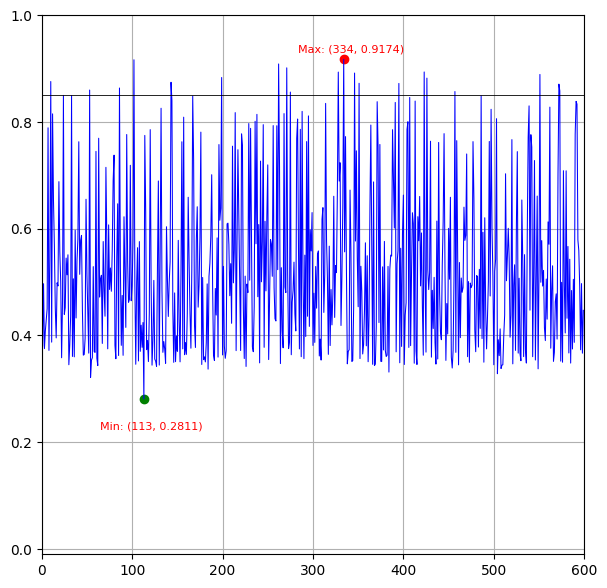

In [157]:
x = range(0, K)
y = [ yi[0] for yi in check_group ]
max_index = np.argmax(y)
max_x = x[max_index]
max_y = y[max_index]

min_index = np.argmin(y)
min_x = x[min_index]
min_y = y[min_index]

plt.figure(figsize=[7, 7])
plt.plot(x, y, '-', linewidth=0.75, color='blue')
plt.scatter(max_x, max_y, color='red', label='Максимальный элемент')
plt.annotate(f'Max: ({max_x}, {max_y:.4f})', (max_x, max_y), textcoords="offset points", 
             xytext=(5,5), ha='center', fontsize=8, color='red')
plt.scatter(min_x, min_y, color='green', label='Минимальный элемент')
plt.annotate(f'Min: ({min_x}, {min_y:.4f})', (min_x, (min_y - 0.07)), textcoords="offset points", 
             xytext=(5,5), ha='center', fontsize=8, color='red')
plt.hlines(cutoff, 0, K, linewidth=0.6, color='black')
plt.xlim(0, K)
plt.ylim(-0.01, 1.0)
plt.grid()
plt.show()

0.8891313855388385


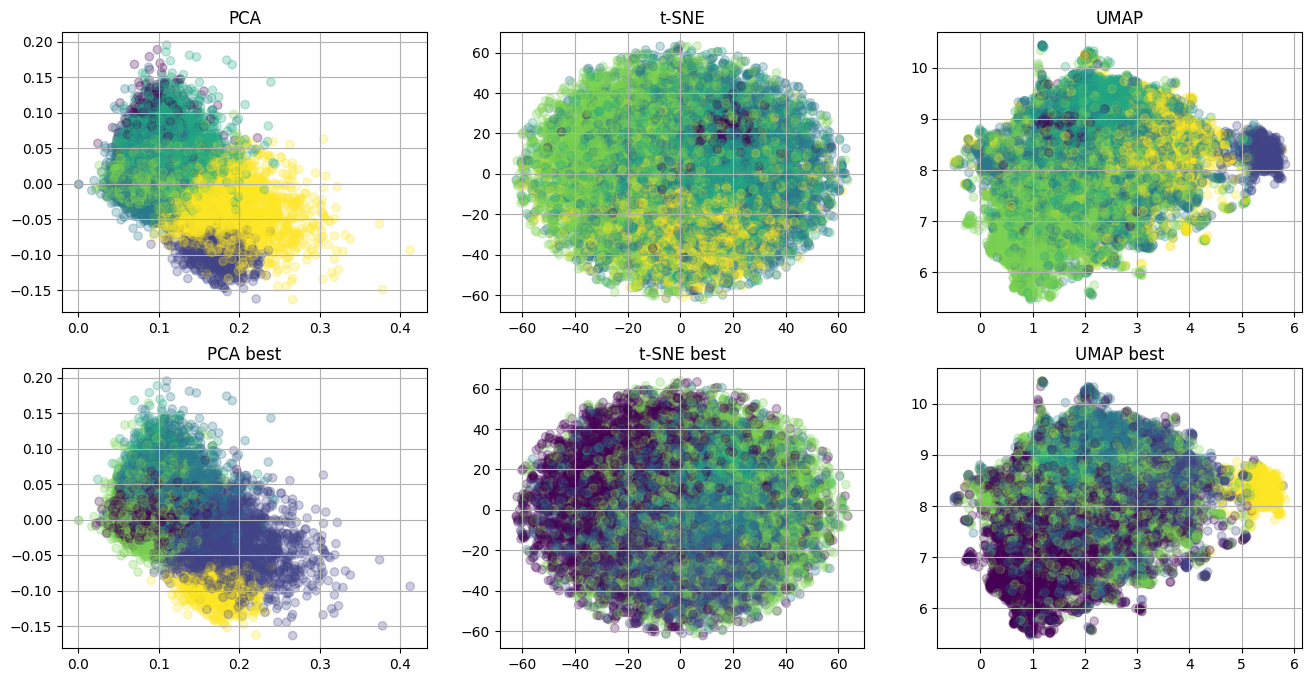

In [197]:
index = 551
print(adjusted_rand_score(best_score, check_group[index][1]))
plotMetricsResult(best_score, check_group[index][1])

In [163]:
saveLabels(check_group[index][1])

Эксперимент оказался не удачным. Значения были чуть ниже лучшего *score*

## Вывод

Не удалось достичь результата выше little_complicated (>0.127). Где-то упустил что-то не очевидное...

Отдельно можно отметить:

* По *визуализации* стоит строить 3д графики, а не 2д более пространственное представление о данных показывает. Но почему то графики, которые у меня строились были без интерактивы. По этому только тепловые карты плотности.

* В PCA(SVD) из за того что матрица разряженная не удалось определить оптимальное число главных компонентов, не использовался.

* В t-SNE данные слишком сгруппированные получаются

* В UMAP уже видно четко выделенное кол-во кластеров(ядер)

* Модели на уменьшенных размерах показывали "*странноватый*" результат. Будто прямыми делили, как результат многие данные перемешивались

Лучший score: **0.12049660758684722**